In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import re

In [2]:
import sys
import os
#floatX = 'float32'
#device = 'cuda0'

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [4]:
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, merge, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from sklearn.model_selection import train_test_split, cross_val_score

In [5]:
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11162563554701232207
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3150367948
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17310591388094435981
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [6]:
MAX_SEQUENCE_LENGTH = 500
MAX_NB_WORDS = 50000
EMBEDDING_DIM = 200

In [7]:
path_Corpus = 'F:/Data/TextDL_Learn/TextCorpus/'
Glove_dir = 'F:/Data/TextDL_Learn/Glove/'
corpa_name = path_Corpus + 'DL_Text_corpus_NATOupdated.txt'
label_values = path_Corpus + 'Label_numbersNATO.txt'

np.set_printoptions(threshold=np.inf)
#get corpus --> list 
#get corpus labels --> list

with open(corpa_name) as corpus:
    texts = corpus.readlines()
with open(label_values) as flabel:
    labels = flabel.readlines()

In [8]:
#tokenize

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

In [9]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 273612 unique tokens.


In [10]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [11]:
labels = np.matrix(labels, dtype=int)
labels = np.transpose(labels) 
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (17498, 500)
Shape of label tensor: (17498, 1)


In [12]:
#print first few labels
#print(data[:5])
#print(labels[50:55])

In [13]:
#data tensor length , evenly spaced interval 
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

#train and test split 80% train and remaining for test samples
#Of the 80% test use 10% for validation
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)

In [14]:
# view the  count and sample
print("total train docs", len(X_train) )
print("total test docs",len(X_test))

total train docs 13998
total test docs 3500


In [15]:
print('Traing and validation set label, encode summation row wise')
print (y_train.sum(axis=0))
print (y_test.sum(axis=0))
print('Traing and validation set data, encode summation row wise')
#print (X_train.sum(axis=0))
#print (X_test.sum(axis=0))
print(data.shape)
print(labels.shape)

Traing and validation set label, encode summation row wise
[[12512]]
[[3059]]
Traing and validation set data, encode summation row wise
(17498, 500)
(17498, 1)


In [16]:
# use glove embeddings, in dictionary
# first word of line in Glove is word level and next are coeffs
# get all words --> word list, corrosponding coeffs at ---> coefs list
# be cautious, if no word match from glove with corpus???

embeddings_index = {}
Glove_100d = Glove_dir + 'glove.6B.200d.txt'
with open(Glove_100d, encoding = "utf-8") as f:
    for line in f:
#        print(line)
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

#print(embeddings_index[:2])    

In [17]:
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [18]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
#print(embedding_matrix[0])
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [19]:
print(embedding_matrix.shape)

(273613, 200)


In [20]:
#print("sample embed for word",embeddings_index['treaty'])

In [21]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
preds = Dense(4,activation='softmax')(l_lstm)
model = Model(sequence_input, preds)

Instructions for updating:
Colocations handled automatically by placer.


In [22]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [23]:
print("model fitting - Bidirectional LSTM")
model.summary()

model fitting - Bidirectional LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 200)          54722600  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 804       
Total params: 54,964,204
Trainable params: 54,964,204
Non-trainable params: 0
_________________________________________________________________


In [24]:
#split training to --> train and validate sets
X_newtrain, X_newval, y_newtrain, y_newval = train_test_split(X_train, y_train, test_size=0.1, random_state=10)

In [25]:
# view the  count and sample
print("Total docs trained ", len(X_newtrain) )
print("Total validation docs for verify",len(X_newval))

Total docs trained  12598
Total validation docs for verify 1400


In [26]:
early_stopping = EarlyStopping(monitor='val_loss', patience=0, verbose=1, mode='auto')

In [27]:
model.fit(X_newtrain, y_newtrain, validation_data=(X_newval, y_newval[:,0]),
          epochs=10, verbose=1, batch_size=50,callbacks=[early_stopping])

Instructions for updating:
Use tf.cast instead.
Train on 12598 samples, validate on 1400 samples
Epoch 1/10
12598/12598 [==============================] - 425s 34ms/step - loss: 1.0351 - acc: 0.5903 - val_loss: 0.9645 - val_acc: 0.6307
Epoch 2/10
12598/12598 [==============================] - 422s 33ms/step - loss: 0.8768 - acc: 0.6600 - val_loss: 0.8858 - val_acc: 0.6521
Epoch 3/10
12598/12598 [==============================] - 490s 39ms/step - loss: 0.7684 - acc: 0.7072 - val_loss: 0.8567 - val_acc: 0.6793
Epoch 4/10
12598/12598 [==============================] - 489s 39ms/step - loss: 0.6664 - acc: 0.7528 - val_loss: 0.8641 - val_acc: 0.6921
Epoch 5/10
12598/12598 [==============================] - 490s 39ms/step - loss: 0.5615 - acc: 0.7978 - val_loss: 0.8870 - val_acc: 0.6729
Epoch 6/10
12598/12598 [==============================] - 492s 39ms/step - loss: 0.4626 - acc: 0.8397 - val_loss: 0.9679 - val_acc: 0.6764
Epoch 00006: early stopping


In [28]:
listofLabels = ['unclassified','confidential', 'secret', 'restricted']
#label dictionary
dictOfLabels = { i : listofLabels[i] for i in range(0, len(listofLabels) ) }
print(dictOfLabels)

{0: 'unclassified', 1: 'confidential', 2: 'secret', 3: 'restricted'}


In [29]:
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing,metrics 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [30]:
score = model.evaluate(X_test, y_test,
                       batch_size=50, verbose=1)
print('Test accuracy:', score[1])

3500/3500 [==============================] - 37s 10ms/step
Test accuracy: 0.6868571443217141


In [31]:
print("Test loss: ",score[0],',Test accuracy:', score[1])

Test loss:  0.9075852853911264 ,Test accuracy: 0.6868571443217141


In [32]:
class_prediction = model.predict(X_test, verbose= 1)

3500/3500 [==============================] - 54s 15ms/step


In [33]:
import itertools

In [34]:
y_pred = class_prediction.argmax(axis=1)
#y_val = np.concatenate([np.array(i) for i in y_test])


In [35]:
print("list of lables:", listofLabels)
print("generated prediction shape:",class_prediction.shape)
print("converted prediction shape:",y_pred.shape)
print("current test shape:",y_test.shape)
#print(np.array(y_pred))

list of lables: ['unclassified', 'confidential', 'secret', 'restricted']
generated prediction shape: (3500, 4)
converted prediction shape: (3500,)
current test shape: (3500, 1)


In [36]:
new_y = np.reshape(y_pred,(y_test.shape))
#print(new_y)
print(new_y.shape)

(3500, 1)


In [37]:
cm = confusion_matrix(y_test, new_y)
print(cm)

[[1570   79   73  121]
 [ 236  394   26  112]
 [ 162   33  142   39]
 [ 164   40   11  298]]


In [38]:
accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy

print(accuracy)

0.6868571428571428


In [39]:
def plot_confusion_matrix(cm,accuracy,misclass,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()



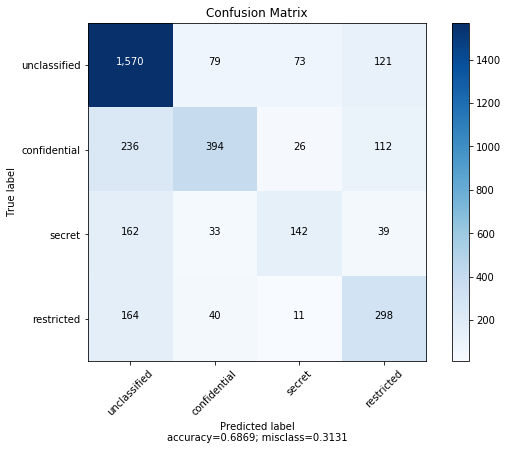

In [40]:
plot_confusion_matrix(cm,accuracy,misclass, normalize = False, 
                      target_names = ['unclassified', 'confidential', 'secret', 'restricted'], 
                      title = "Confusion Matrix" )

In [41]:
class AttLayer(Layer):
    def __init__(self,attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(AttLayer, self).__init__()
    
    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init((self.attention_dim, )))
        self.u = K.variable(self.init((self.attention_dim, 1)))
        self.trainable_weights = [self.W, self.b, self.u]
        super(AttLayer, self).build(input_shape)
        
    def compute_mask(self, inputs, mask=None):
        return mask
    
    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)

        ait = K.exp(ait)
        
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = x * ait
        output = K.sum(weighted_input, axis=1)

        return output
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


In [42]:
l_gru = Bidirectional(GRU(100, return_sequences=True))(embedded_sequences)
l_att = AttLayer(1)(l_gru)
preds = Dense(4, activation='softmax')(l_att)
Attn_model = Model(sequence_input, preds)
Attn_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("model fitting - attention GRU network")
Attn_model.summary()

model fitting - attention GRU network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 200)          54722600  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 500, 200)          180600    
_________________________________________________________________
att_layer_1 (AttLayer)       (None, 200)               202       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 804       
Total params: 54,904,206
Trainable params: 54,904,206
Non-trainable params: 0
_________________________________________________________________


In [43]:
Attn_model.fit(X_newtrain, y_newtrain[:,0], validation_data=(X_newval, y_newval[:,0]),
          epochs=10, verbose=1, batch_size=50, callbacks=[early_stopping])

Train on 12598 samples, validate on 1400 samples
Epoch 1/10
12598/12598 [==============================] - 432s 34ms/step - loss: 1.0765 - acc: 0.5674 - val_loss: 0.9086 - val_acc: 0.6471
Epoch 2/10
12598/12598 [==============================] - 425s 34ms/step - loss: 0.7808 - acc: 0.7012 - val_loss: 0.7543 - val_acc: 0.7193
Epoch 3/10
12598/12598 [==============================] - 429s 34ms/step - loss: 0.6297 - acc: 0.7654 - val_loss: 0.7249 - val_acc: 0.7350
Epoch 4/10
12598/12598 [==============================] - 400s 32ms/step - loss: 0.5148 - acc: 0.8119 - val_loss: 0.7829 - val_acc: 0.7343
Epoch 5/10
12598/12598 [==============================] - 346s 27ms/step - loss: 0.4080 - acc: 0.8580 - val_loss: 0.8108 - val_acc: 0.7314
Epoch 6/10
12598/12598 [==============================] - 347s 28ms/step - loss: 0.3070 - acc: 0.8919 - val_loss: 0.9194 - val_acc: 0.6964
Epoch 00006: early stopping


In [44]:
score_atten = Attn_model.evaluate(X_test, y_test,
                       batch_size=50, verbose=1)
print('Test accuracy:', score_atten[1])

3500/3500 [==============================] - 30s 8ms/step
Test accuracy: 0.7140000028269632


In [45]:
class_prediction_atten = Attn_model.predict(X_test, verbose= 1)
y_pred_atten = class_prediction_atten.argmax(axis=1)

3500/3500 [==============================] - 46s 13ms/step


In [46]:
print(y_test.shape)
attn_y = np.reshape(y_pred_atten,(y_test.shape))
#print(new_y)
print(attn_y.shape)
attn_cm = confusion_matrix(y_test, attn_y )
print(attn_cm)

(3500, 1)
(3500, 1)
[[1512  119   96  116]
 [ 205  462   47   54]
 [ 143   19  201   13]
 [ 118   44   27  324]]


In [47]:
accuracy_attn = np.trace(attn_cm) / float(np.sum(attn_cm))
misclass_attn = 1 - accuracy_attn

print(accuracy_attn)

0.714


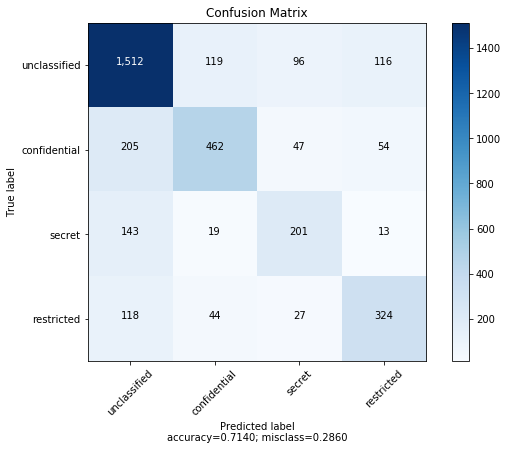

In [48]:
plot_confusion_matrix(attn_cm, accuracy_attn, misclass_attn, normalize = False, 
                      target_names = ['unclassified', 'confidential', 'secret', 'restricted'], title = "Confusion Matrix")